# Model architecture

In [19]:
import numpy as np
from tqdm import tqdm

class RecommendationSystem():
    def __init__(self, user_features, item_features, latent_dim=10, lr=1e-2, lr_decay=0.95, reg=0.1, epochs=1000):
        self.latent_dim = latent_dim
        self.lr = lr
        self.lr_decay = lr_decay
        self.reg = reg
        self.epochs = epochs
        self.user_features = user_features
        self.item_features = item_features

        self.n_users = self.user_features.shape[0]
        self.n_items = self.item_features.shape[0]
        self.n_user_features = self.user_features.shape[1]
        self.n_item_features = self.item_features.shape[1]

        # manual seeding
        np.random.seed(2)
        self.user_matrix = np.random.normal(size=(self.n_users, self.latent_dim))
        np.random.seed(2)
        self.item_matrix = np.random.normal(size=(self.n_items, self.latent_dim))

    def fit(self, X, y=None): # y is user for error evaluation; not training !
        self.train_e_vector = list()
        self.train_acc_vector = list()
        self.train_pres_vector = list()
        self.test_e_vector = list()
        self.test_acc_vector = list()
        self.test_pres_vector = list()
        pbar = tqdm(range(self.epochs))
        for epoch in pbar:
            for u_idx in range(X.shape[0]):
                for i_idx in range(X.shape[1]):
                    u = self.user_matrix[u_idx, :]
                    i = self.item_matrix[i_idx, :]
                    truth = X[u_idx][i_idx]
                    if not truth: continue

                    error = truth - u@i
                    u_grad = self.reg*u - error*i
                    i_grad = self.reg*i - error*u

                    self.user_matrix[u_idx, :] -= self.lr * u_grad
                    self.item_matrix[i_idx, :] -= self.lr * i_grad

            self.lr *= self.lr_decay
            if y is not None:
                self.predict()

                train_e = self.get_rmse(X)
                test_e = self.get_rmse(y) * (np.count_nonzero(X)/np.count_nonzero(y)) # adjustment for error values because train is a couple of times larger than test
                func = np.vectorize(lambda l: 1 if l>3.5 else -1 if l>0 else 0)
                train_acc = self.get_accuracy(func(X))
                test_acc = self.get_accuracy(func(y))
                train_pres = self.get_precision(func(X))
                test_pres = self.get_precision(func(y))

                self.train_e_vector.append(train_e)
                self.train_acc_vector.append(train_acc)
                self.test_e_vector.append(test_e)
                self.test_acc_vector.append(test_acc)
                self.train_pres_vector.append(train_pres)
                self.test_pres_vector.append(test_pres)
                pbar.set_postfix_str(
                    f"TRAIN RMSE:{round(train_e, 3)}  TRAIN ACC:{round(train_acc, 3)}%  TRAIN PRES:{round(train_pres, 3)}%  TEST RMSE:{round(test_e, 3)}  TEST ACC:{round(test_acc, 3)}%  TEST PRES:{round(test_pres, 3)}"
                )


    def predict(self):
        self.pred = self.user_matrix @ np.transpose(self.item_matrix)
        self.pred_flat = np.vectorize(lambda l: 1 if l>=3.5 else -1)(self.pred)
        return self.pred


    def get_rmse(self, y):
        rmse = (y - self.pred) ** 2
        rmse = np.mean(rmse * (y!=0)) ** 0.5
        return rmse


    def get_accuracy(self, y_flat):
        return np.sum(self.pred_flat==y_flat) * 100 / np.sum(y_flat!=0)


    def get_precision(self, y_flat):
        tp = np.sum((self.pred_flat==1)&(y_flat==1))
        tp_and_fp = np.sum((self.pred_flat==1)&(y_flat!=0))
        return tp*100 / tp_and_fp


    def get_diversity(self):
        sim = dict()
        for i in range(self.n_items):
            for j in range(i+1, self.n_items):
                sim[(i+1, j+1)] = (self.item_features[i] @ self.item_features[j]) / self.n_item_features

        diversity = 0
        pbar = tqdm(range(self.n_users))
        pbar.set_description("Evaluating..")
        for i in pbar:
            liked_items = np.where(self.pred_flat[i]==1)[0] + 1
            n_liked_items = liked_items.size
            if n_liked_items < 2: continue
            sim_val = 0
            for j in range(n_liked_items):
                for k in range(j+1, n_liked_items):
                    sim_val += sim[(liked_items[j], liked_items[k])]
            n_comp = n_liked_items*(n_liked_items-1) / 2
            diversity += sim_val / n_comp
        diversity = 100 * diversity / self.n_users
        diversity_explanation = "Bad; recommendations are too similar" if diversity<5 else "Bad; recommendations are too random" if diversity>7 else "Good; recommendations are not too similar and not too random"
        return diversity, diversity_explanation


    def get_metrics(self, y):
        self.predict()
        y_flat = np.vectorize(lambda l: 1 if l>=4 else -1 if l>0 else 0)(y)
        return {
            "rmse": self.get_rmse(y),
            "accuracy": self.get_accuracy(y_flat),
            "precision": self.get_precision(y_flat),
            "diversity": self.get_diversity() # returns two values
        }


    def recommend_items(self, K=5, user_id=None, user_features=None):
        if (user_id is None) == (user_features is None):
            print("It is required to pass either 'user_id' or 'user_features' to recommend items")
            return None

        if user_id is not None:
            self.predict()
            pred = self.pred[user_id-1]
            suggested_items = np.argsort(pred)[:-(K+1):-1]
            return suggested_items

        if user_features is not None:
            N = 5 # how many similar users will be used to make predictions
            sims = [
                np.dot(x, user_features) / (np.linalg.norm(x)*np.linalg.norm(user_features))
                for x in self.user_features
            ]
            sim_users = np.argsort(sims)[:-(N+1):-1]

            self.predict()
            ratings = 0
            for user in sim_users: ratings += self.pred[user]
            suggested_items = np.argsort(ratings)[:-(K+1):-1]
            return suggested_items


# Model training

In [20]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import pickle

user_features_path = "/content/u.user.csv"
item_features_path = "/content/u.item.csv"
occupations_path = "/content/u.occupation.csv"
item_names_path = "/content/u.item_names.csv"
X_path = "/content/u1.base.csv"
y_path = "/content/u1.test.csv"

user_features = pd.read_csv(user_features_path, index_col="user_id").to_numpy()
item_features = pd.read_csv(item_features_path, index_col="Unnamed: 0").to_numpy()
occup = pd.read_csv(occupations_path)
item_names = pd.read_csv(item_names_path)
X = pd.read_csv(X_path, index_col="User id").to_numpy()
y = pd.read_csv(y_path, index_col="User id").to_numpy()

In [37]:
print(f"\nTrain: {X_path}   Test: {y_path}")
rs = RecommendationSystem(user_features, item_features, epochs=100)
rs.fit(X, y)

score = rs.get_metrics(y)
print(f"RMSE:      {round(score['rmse'], 5)}")
print(f"Accuracy:  {round(score['accuracy'], 5)}%")
print(f"Precision: {round(score['precision'], 5)}%")
print(f"Diversity: {round(score['diversity'][0], 5)}%  {score['diversity'][1]}\n")


Train: /content/u1.base.csv   Test: /content/u1.test.csv


Evaluating..: 100%|██████████| 943/943 [01:14<00:00, 12.72it/s]

RMSE:      0.11255
Accuracy:  70.605%
Precision: 76.87676%
Diversity: 2.21706%  Bad; recommendations are too similar



# Model evaluation

## Making suggestions

Let's pretend I'm a 24 year old retired man

In [40]:
age = 24 / 100
sex = 0 # 0 corresponds to male
occup = 15 / 20 # 15 corresponds to retired

items = rs.recommend_items(user_features=[age, sex, occup])
for i in items:
    name = item_names[item_names.item_id == i].item_name.item()
    print(name)

Jupiter's Wife (1994)
Funny Face (1957)
Before the Rain (Pred dozhdot) (1994)
Ruby in Paradise (1993)
Faust (1994)


## Training process plot

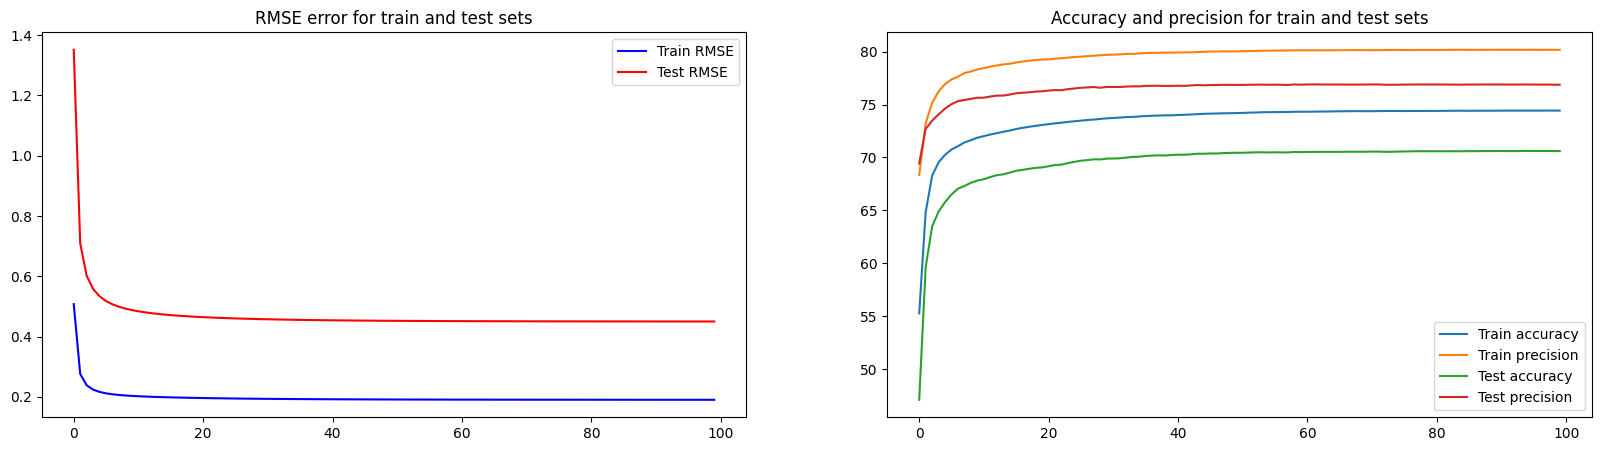

In [41]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(20, 5))
ax1 = axs[0]
ax2 = axs[1]

ax1.plot(rs.train_e_vector, color="blue", label="Train RMSE")
ax1.plot(rs.test_e_vector, color="red", label="Test RMSE")
ax1.legend()
ax1.set_title("RMSE error for train and test sets")

ax2.plot(rs.train_acc_vector, label="Train accuracy")
ax2.plot(rs.train_pres_vector, label="Train precision")
ax2.plot(rs.test_acc_vector, label="Test accuracy")
ax2.plot(rs.test_pres_vector, label="Test precision")
ax2.set_title("Accuracy and precision for train and test sets")
ax2.legend()